<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Lab12-NLP-towards-attention212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [6]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 100_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ValueError: Invalid pattern: '**' can only be an entire path component

In [5]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break


NameError: name 'train_texts' is not defined

## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the rows above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [3]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [5]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cuda


## Plot Function

In [6]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Simple 1 Feature Aproach
------------------

Before we proceed with a multi-feature network, let's try to go simpler, for a moment. Let's consider a single feature.

Working on cuda
Epoch 000 | Train Loss: 0.7007, Acc: 0.4979 | Val Loss: 0.6985, Acc: 0.4962
Epoch 010 | Train Loss: 0.6517, Acc: 0.6052 | Val Loss: 0.6466, Acc: 0.6161
Epoch 020 | Train Loss: 0.5326, Acc: 0.7709 | Val Loss: 0.5270, Acc: 0.7757
Epoch 030 | Train Loss: 0.4468, Acc: 0.8232 | Val Loss: 0.4453, Acc: 0.8217
Epoch 040 | Train Loss: 0.3886, Acc: 0.8521 | Val Loss: 0.3905, Acc: 0.8478
Epoch 050 | Train Loss: 0.3455, Acc: 0.8712 | Val Loss: 0.3507, Acc: 0.8667
Epoch 060 | Train Loss: 0.3124, Acc: 0.8856 | Val Loss: 0.3211, Acc: 0.8786
Epoch 070 | Train Loss: 0.2864, Acc: 0.8954 | Val Loss: 0.2989, Acc: 0.8876
Epoch 080 | Train Loss: 0.2657, Acc: 0.9032 | Val Loss: 0.2822, Acc: 0.8931
Epoch 090 | Train Loss: 0.2491, Acc: 0.9090 | Val Loss: 0.2696, Acc: 0.8969
Epoch 100 | Train Loss: 0.2355, Acc: 0.9141 | Val Loss: 0.2604, Acc: 0.9018
Epoch 110 | Train Loss: 0.2243, Acc: 0.9178 | Val Loss: 0.2536, Acc: 0.9041
Epoch 120 | Train Loss: 0.2148, Acc: 0.9215 | Val Loss: 0.2488, Acc: 0.9

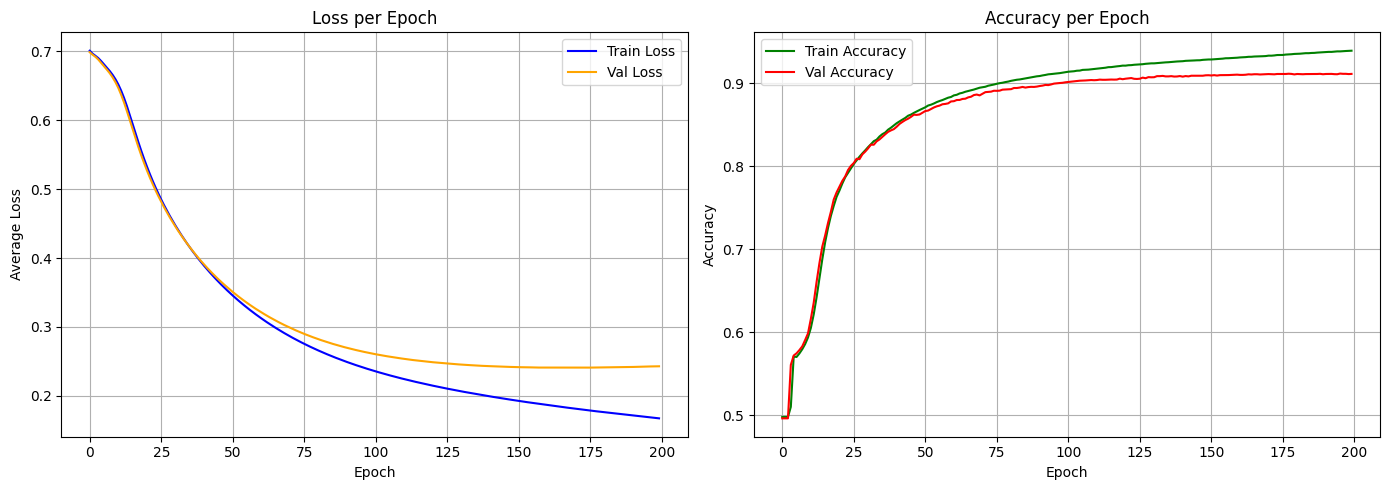

In [7]:
feature_cnt = 1
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_1 = Net_1()

# Execute training
train_loss, val_loss, train_acc, val_acc = train_model(net_1, train_loader, val_loader, epochs = 200)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Sentiment Polarity

Since our embeddings have only 1 feature (`feature_cnt = 1`), each word is embedded to a scalar. We can interpret this scalar as a kind of sentiment polarity, especially since our model is trained for sentiment classification.

In [ ]:
import numpy as np

# Get the embedding weights as a NumPy array
embedding_weights = net_1.embedding.weight.detach().cpu().numpy().squeeze()  # shape: (vocab_len,)

# Reverse vocab dictionary to map indices back to words
id2token = {idx: token for token, idx in vocab.items()}

# Skip <PAD> and <UNK> tokens (indices 0 and 1)
valid_indices = np.array([idx for idx in range(2, len(embedding_weights)) if idx in id2token])
valid_embeddings = embedding_weights[valid_indices]

# Sort and select indices
sorted_pos = np.argsort(-valid_embeddings)
sorted_neg = np.argsort(valid_embeddings)
sorted_neutral = np.argsort(np.abs(valid_embeddings))

top_pos_indices = valid_indices[sorted_pos[:20]]
top_neg_indices = valid_indices[sorted_neg[:20]]
top_neutral_indices = valid_indices[sorted_neutral[:20]]

# Print words and corresponding embedding values
def print_words_with_embeddings(indices, title):
    print(f"\n{title}")
    for idx in indices:
        word = id2token[int(idx)]
        value = embedding_weights[int(idx)]
        print(f"{word:15} -> {value:.4f}")

print_words_with_embeddings(top_pos_indices, "Top 20 most positive words:")
print_words_with_embeddings(top_neg_indices, "Top 20 most negative words:")
print_words_with_embeddings(top_neutral_indices, "Top 20 most neutral words:")



Top 20 most positive words:
delicious       -> 13.2235
excellent       -> 12.7576
phenomenal      -> 12.7009
awesome         -> 12.2002
fantastic       -> 11.9967
pleasantly      -> 11.8967
amazing         -> 11.7529
perfection      -> 11.6419
gem             -> 11.4302
ngreat          -> 11.3560
incredible      -> 11.2053
yum             -> 11.0856
perfect         -> 10.7907
glad            -> 10.2746
perfectly       -> 9.9910
yummy           -> 9.9270
addicted        -> 9.8642
wonderful       -> 9.5822
pleased         -> 9.5092
superb          -> 9.4010

Top 20 most negative words:
mediocre        -> -16.5915
bland           -> -16.3095
worst           -> -15.1473
horrible        -> -14.6822
disgusting      -> -14.6809
disappointing   -> -14.3393
terrible        -> -14.3263
meh             -> -13.8851
overpriced      -> -13.3517
tasteless       -> -12.8738
awful           -> -12.5062
unfortunately   -> -12.2981
unimpressed     -> -12.1688
poorly          -> -12.1054
rude            

## Classificator

It is interesting to see how the polar sentiment gets translated into the two  class values. Let's see:

In [ ]:
# Extract weights and bias from the classifier layer
classifier_weight = net_1.classifier.weight.detach().cpu().numpy()
classifier_bias = net_1.classifier.bias.detach().cpu().numpy()

print("Classifier weights (shape: {}):".format(classifier_weight.shape))
print(classifier_weight)

print("\nClassifier bias (shape: {}):".format(classifier_bias.shape))
print(classifier_bias)

print("Recall our coding: ")
print(label_map)


Classifier weights (shape: (1, 1)):
[[14.786245]]

Classifier bias (shape: (1,)):
[-0.9344499]
Recall our coding: 
{0: 'negative', 1: 'positive'}


In [ ]:
# Hand-picked test sentences
texts = [
    "I love this",
    "I like this",
    "I do not like this",
    "I don't like this",
    "This is terrible",
    "Thank you so much!",
    "I hate this",
    "I don't hate this",
    "This sucks!"
]

# Convert texts to input_ids using your tokenizer
input_ids = process_texts(texts, vocab)
input_tensor = torch.tensor(input_ids).to(next(net_1.parameters()).device)

# Predict with trained model
net_1.eval()
with torch.no_grad():
    logits = net_1(input_tensor).squeeze()
    probs = torch.sigmoid(logits)

# Print results
for text, prob in zip(texts, probs):
    print(f"{text:30} -> predicted probability of POSITIVE: {prob.item():.4f}")


I love this                    -> predicted probability of POSITIVE: 0.7463
I like this                    -> predicted probability of POSITIVE: 0.5497
I do not like this             -> predicted probability of POSITIVE: 0.3569
I don't like this              -> predicted probability of POSITIVE: 0.4834
This is terrible               -> predicted probability of POSITIVE: 0.1831
Thank you so much!             -> predicted probability of POSITIVE: 0.7319
I hate this                    -> predicted probability of POSITIVE: 0.4095
I don't hate this              -> predicted probability of POSITIVE: 0.3470
This sucks!                    -> predicted probability of POSITIVE: 0.2298


# Adding Artificial (Concatenated) Sentences
-----------------

It will make the dataset diffinitely more demanding and also more suited for attention that we intend to add later.

Every original sentence appears as the second part of a mixed sentence, so every label is retained. Next, a second randomly selected sentence is prepended — that is, added to the beginning of the original sentence. As an effect, we generate as many augmented samples as there are originals. The number of samples and the label distribution is retained.

The classifier must learn to focus on the main sentence and ignore the distractor that is added. This provides a clear, controlled task that makes attention valuable:
 - **With attention**: the model can learn to give weight to the main part. It must also learn to disregard `<PAD>` tokens that follow.
 - **Without attention**: a mean-pool model may be diluted by the additional sentence.

In [ ]:

import random

MAX_LEN = 256  # changing max len to accomodate longer sequences, also, longer sequences are harder for the mean network

def pair_every_sentence_with_random(texts, labels, seed=42):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)

# Reprocess splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Recalculate data loaders
train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# More Features, Now
---------------

Working on cuda
Epoch 000 | Train Loss: 0.6588, Acc: 0.6142 | Val Loss: 0.6248, Acc: 0.6823
Epoch 010 | Train Loss: 0.2323, Acc: 0.9166 | Val Loss: 0.2558, Acc: 0.9054
Epoch 020 | Train Loss: 0.1758, Acc: 0.9383 | Val Loss: 0.2389, Acc: 0.9111
Epoch 030 | Train Loss: 0.1473, Acc: 0.9491 | Val Loss: 0.2461, Acc: 0.9085
Elapsed time: 83.20 seconds


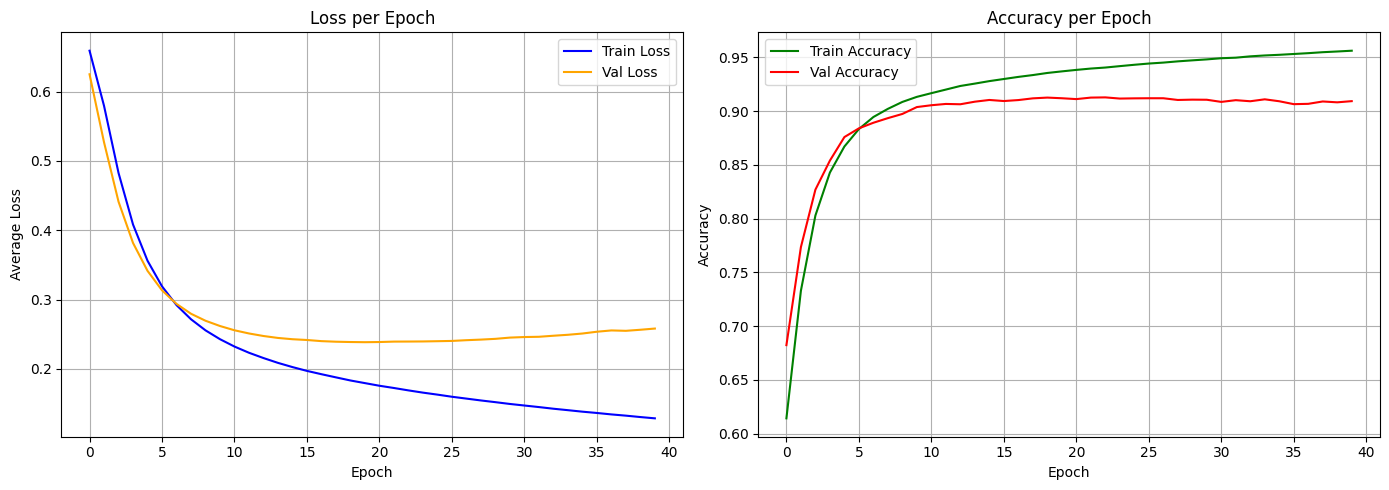

In [248]:
feature_cnt = 200
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_64=Net_F()
train_loss, val_loss, train_acc, val_acc = train_model(net_64, train_loader, val_loader, epochs=40)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*



In [4]:
!pip install transformers datasets matplotlib scikit-learn --quiet

In [9]:
semantic_classes = {
    "Gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("father", "mother"),
        ("prince", "princess"),
        ("boy", "girl")
    ],
    "Verb Tense": [
        ("go", "went"),
        ("buy", "bought"),
        ("take", "took"),
        ("eat", "ate"),
        ("run", "ran")
    ],
    "Singular/Plural": [
        ("cat", "cats"),
        ("dog", "dogs"),
        ("car", "cars"),
        ("child", "children"),
        ("house", "houses")
    ],
    "Comparative/Superlative": [
        ("good", "better"),
        ("bad", "worse"),
        ("big", "bigger"),
        ("fast", "faster"),
        ("happy", "happier")
    ],
    "Country/Capital": [
        ("france", "paris"),
        ("italy", "rome"),
        ("germany", "berlin"),
        ("japan", "tokyo"),
        ("canada", "ottawa")
    ],
    "Tool/Object": [
        ("pen", "paper"),
        ("knife", "bread"),
        ("brush", "paint"),
        ("hammer", "nail"),
        ("keyboard", "screen")
    ],
    "Profession/Object": [
        ("chef", "knife"),
        ("artist", "brush"),
        ("writer", "pen"),
        ("musician", "guitar"),
        ("carpenter", "hammer")
    ],
    "Animal/Sound": [
        ("dog", "bark"),
        ("cat", "meow"),
        ("cow", "moo"),
        ("duck", "quack"),
        ("lion", "roar")
    ],
    "Object/Color": [
        ("grass", "green"),
        ("sky", "blue"),
        ("sun", "yellow"),
        ("rose", "red"),
        ("cloud", "white")
    ],
    "Adjective/Antonym": [
        ("hot", "cold"),
        ("light", "dark"),
        ("happy", "sad"),
        ("strong", "weak"),
        ("easy", "hard")
    ]
}


In [20]:
def validate_semantic_classes(semantic_classes, vocab, token_lists, min_occurrences=2):
    # Licz wystąpienia tokenów w zbiorze danych
    token_freq = collections.Counter(token for tokens in token_lists for token in tokens)
    unk_token_id = vocab.get('<UNK>', 1)

    valid_classes = {}
    invalid_words = set()

    for class_name, pairs in semantic_classes.items():
        valid_pairs = []
        for w1, w2 in pairs:
            id1 = vocab.get(w1, unk_token_id)
            id2 = vocab.get(w2, unk_token_id)
            freq1 = token_freq.get(w1, 0)
            freq2 = token_freq.get(w2, 0)

            # Uznaj za ważne tylko jeśli token NIE jest <UNK> i słowo występuje w korpusie przynajmniej 2 razy
            if id1 != unk_token_id and id2 != unk_token_id and freq1 >= min_occurrences and freq2 >= min_occurrences:
                valid_pairs.append((w1, w2))
            else:
                if id1 == unk_token_id or freq1 < min_occurrences:
                    invalid_words.add(w1)
                if id2 == unk_token_id or freq2 < min_occurrences:
                    invalid_words.add(w2)

        if valid_pairs:
            valid_classes[class_name] = valid_pairs

    return valid_classes, invalid_words


In [187]:
valid_classes, invalid_words = validate_semantic_classes(semantic_classes, vocab, train_tokens)
print("Valid classes:", list(valid_classes.keys()))
print("Invalid words:", sorted(invalid_words))


Valid classes: ['Gender', 'Verb Tense', 'Singular/Plural', 'Comparative/Superlative', 'Country/Capital', 'Tool/Object', 'Profession/Object', 'Animal/Sound', 'Object/Color', 'Adjective/Antonym']
Invalid words: []


In [249]:
embeddings = net_64.embedding.weight.detach().cpu().numpy()  # shape (vocab_len, feature_cnt)


In [250]:
# Zbierz wszystkie unikalne słowa z valid_classes
all_words = []
for pairs in valid_classes.values():
    for w1, w2 in pairs:
        all_words.append(w1)
        all_words.append(w2)
all_words = list(set(all_words))

# Pobierz indeksy słów
word_ids = [vocab[w] for w in all_words]

# Pobierz embeddingi tych słów
word_embeddings = embeddings[word_ids]


In [251]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)


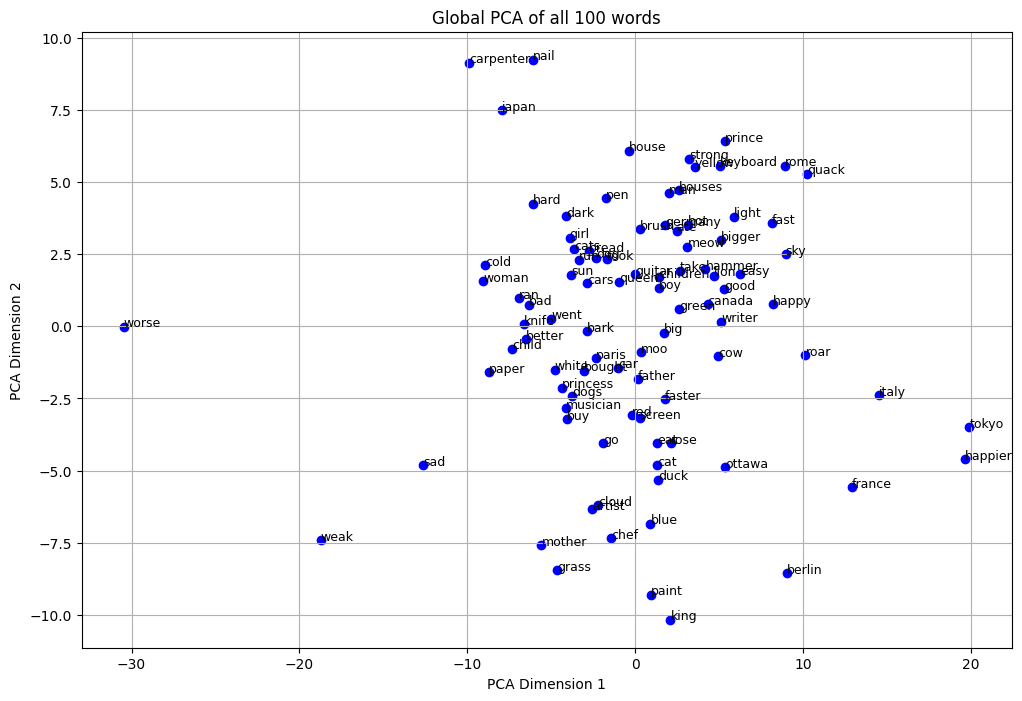

In [236]:
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], color='blue')

for i, word in enumerate(all_words):
    plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=9)

plt.title("Global PCA of all 100 words")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()


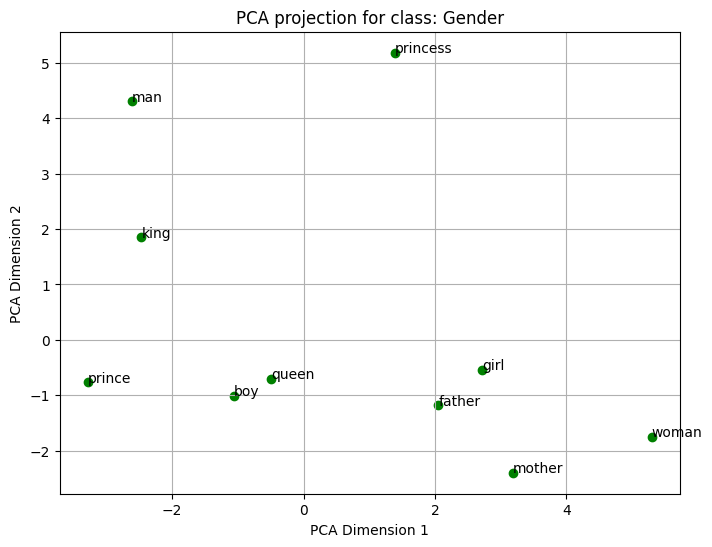

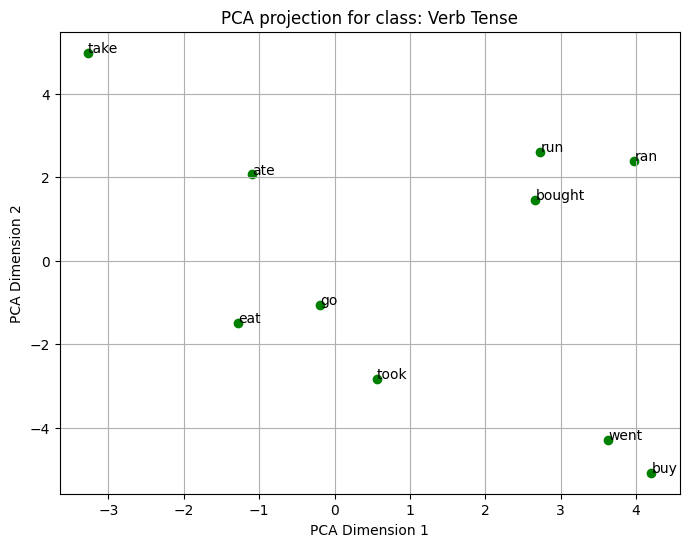

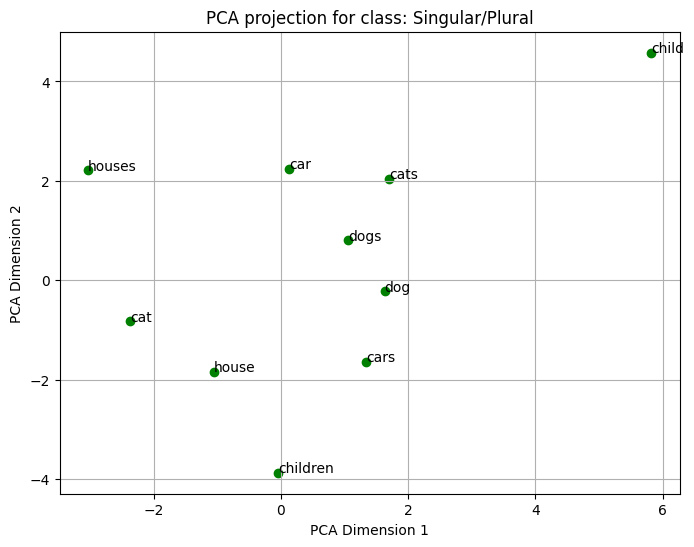

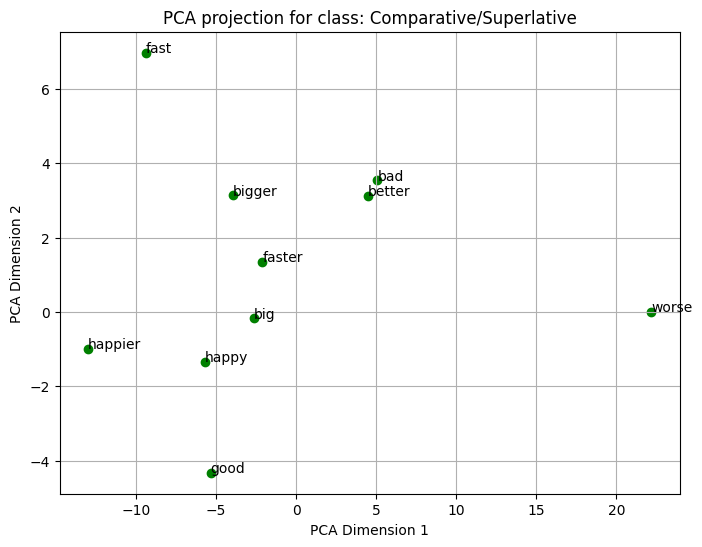

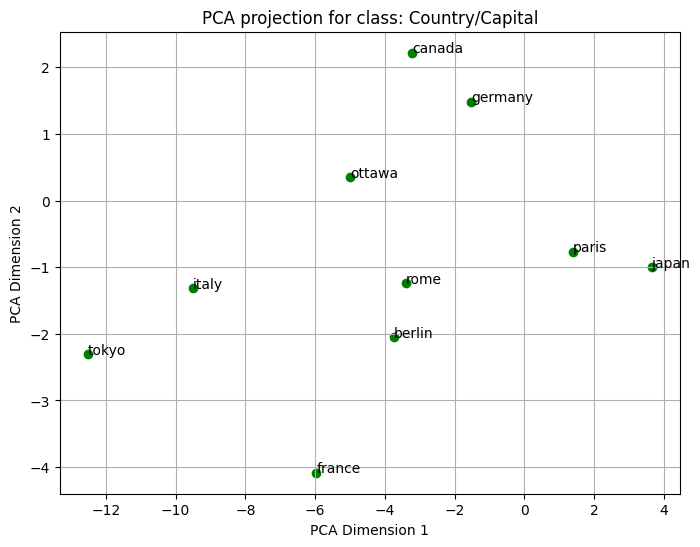

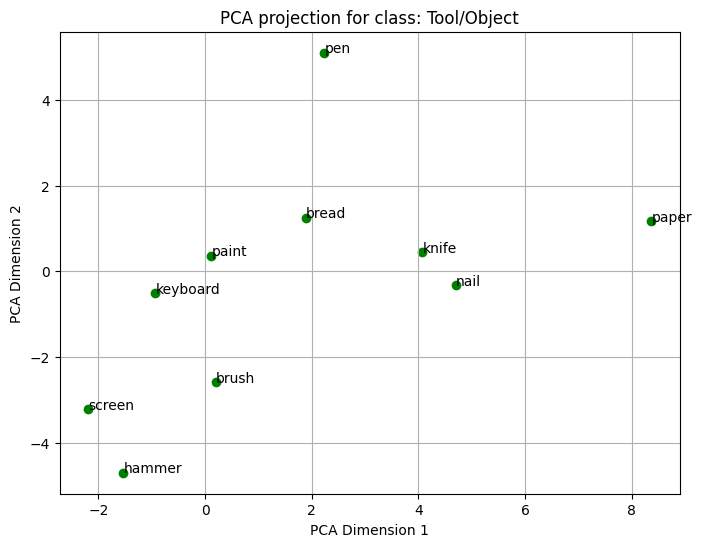

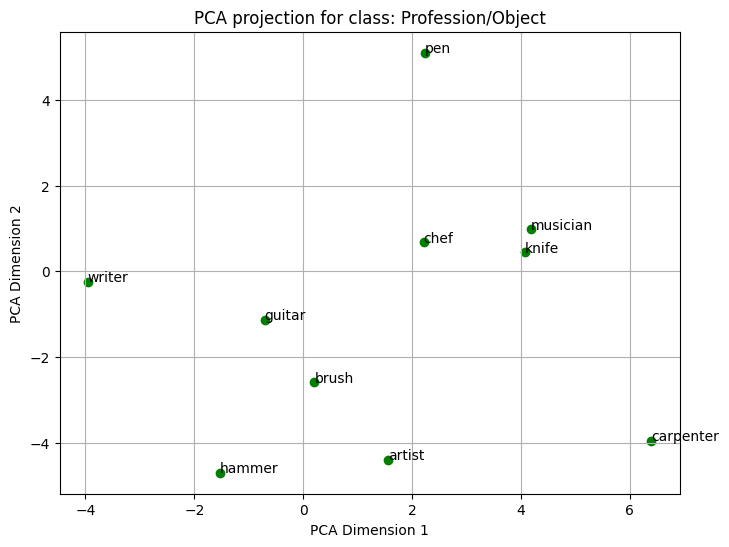

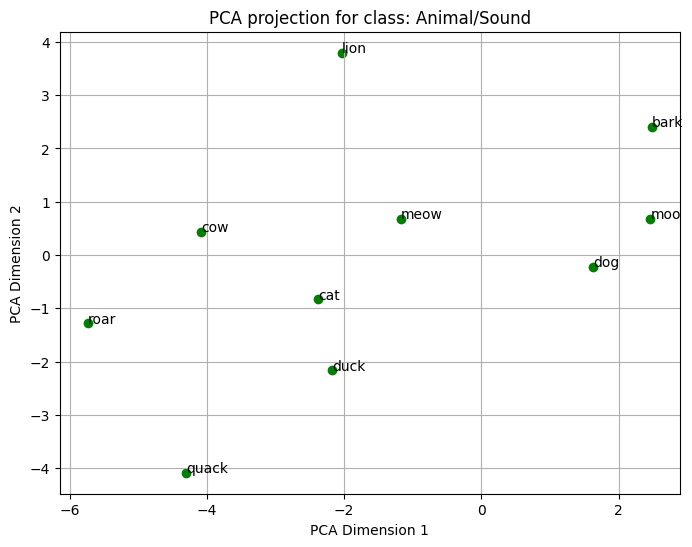

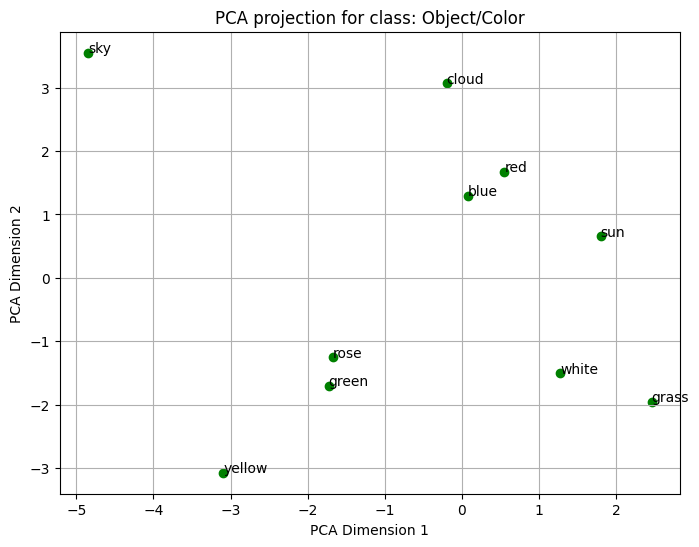

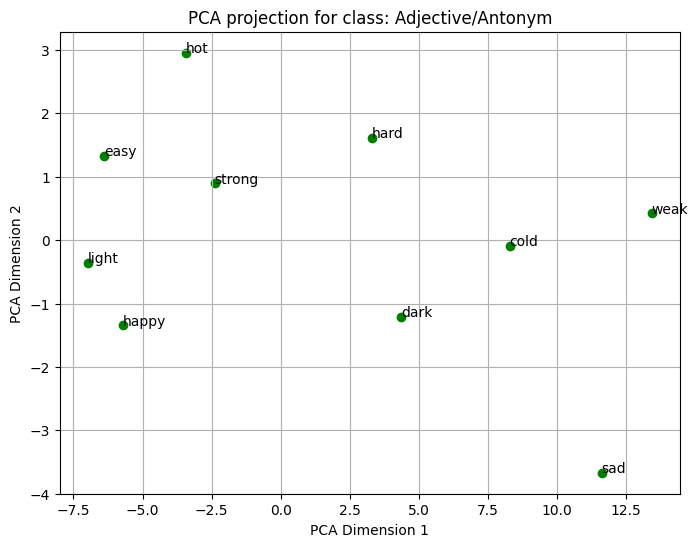

In [252]:
for class_name, pairs in valid_classes.items():
    class_words = []
    for w1, w2 in pairs:
        class_words.append(w1)
        class_words.append(w2)
    class_ids = [vocab[w] for w in class_words]
    class_embeddings = embeddings[class_ids]
    class_embeddings_2d = pca.transform(class_embeddings)  # używamy tej samej transformacji PCA

    plt.figure(figsize=(8, 6))
    plt.scatter(class_embeddings_2d[:, 0], class_embeddings_2d[:, 1], color='green')

    for i, word in enumerate(class_words):
        plt.text(class_embeddings_2d[i, 0], class_embeddings_2d[i, 1], word, fontsize=10)

    plt.title(f"PCA projection for class: {class_name}")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)
    plt.show()


<ipython-input-253-87205b0beb59>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')


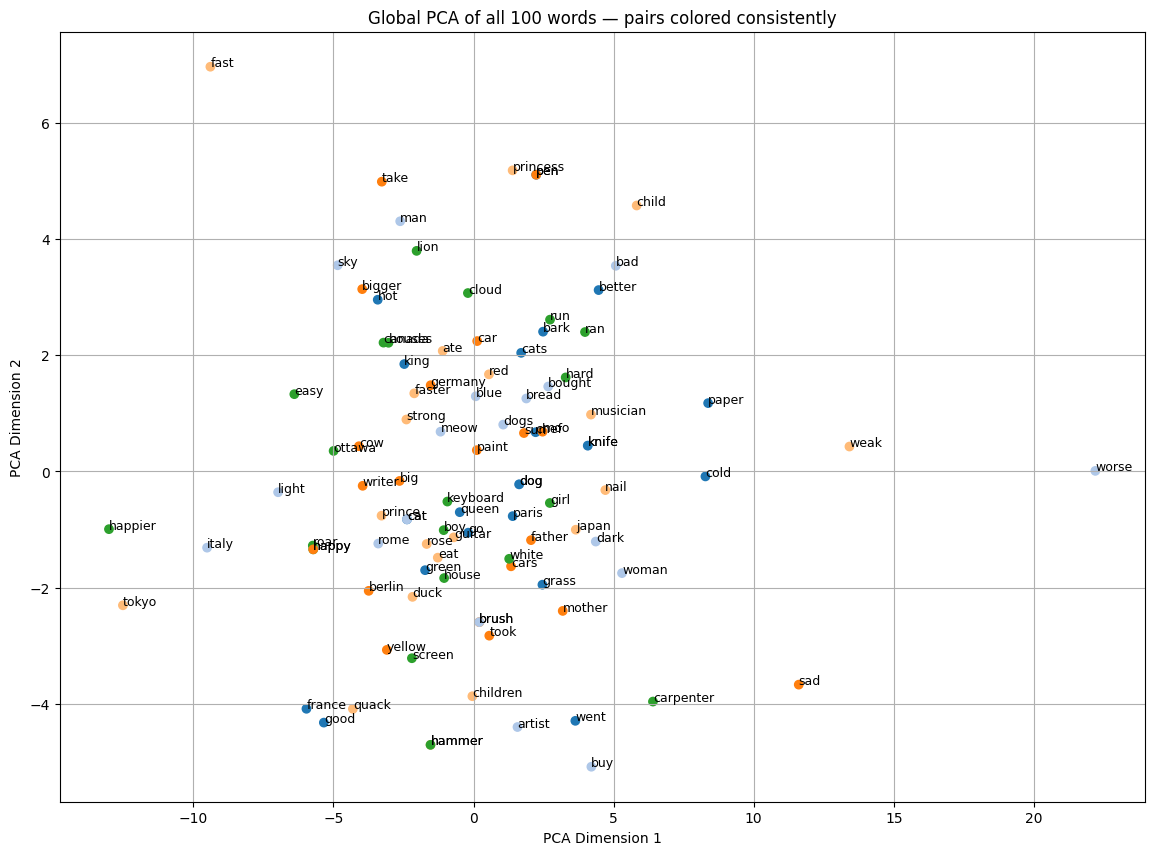

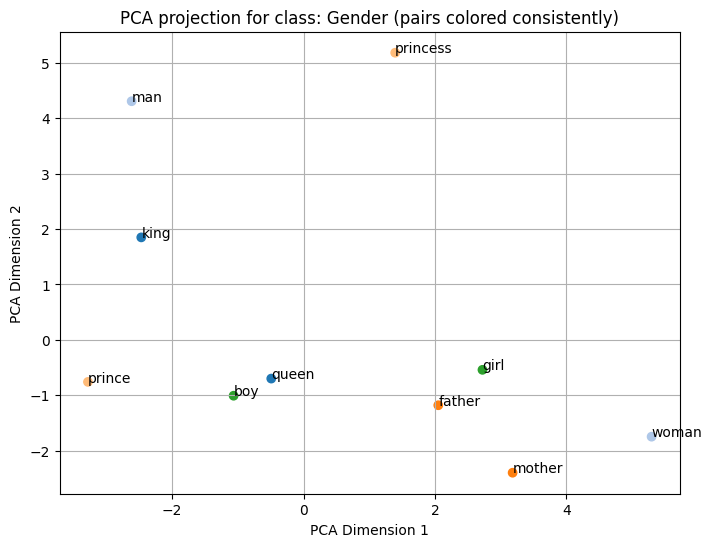

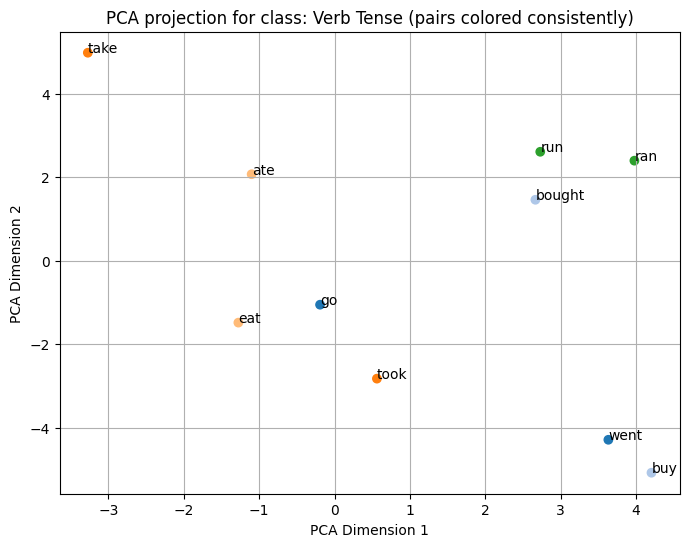

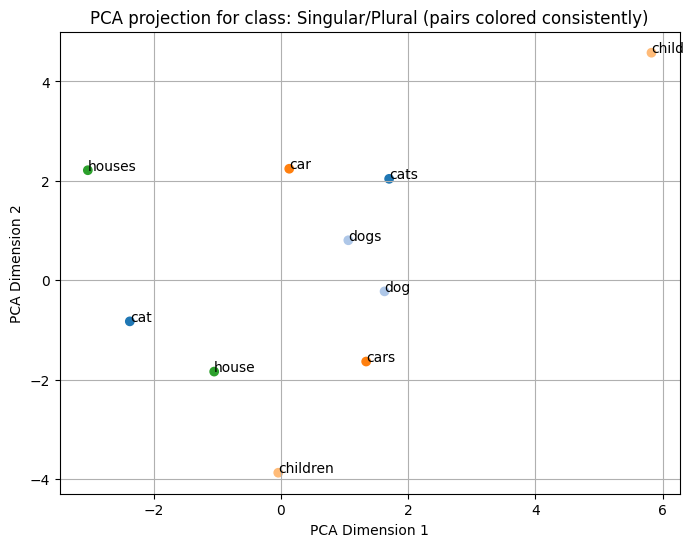

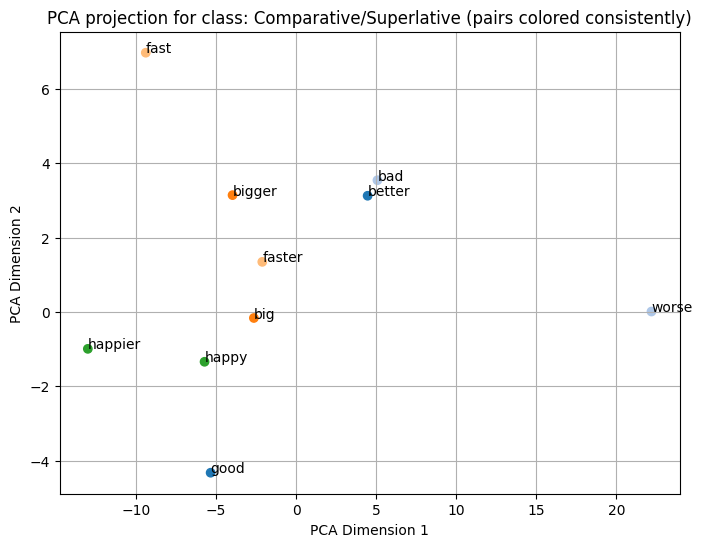

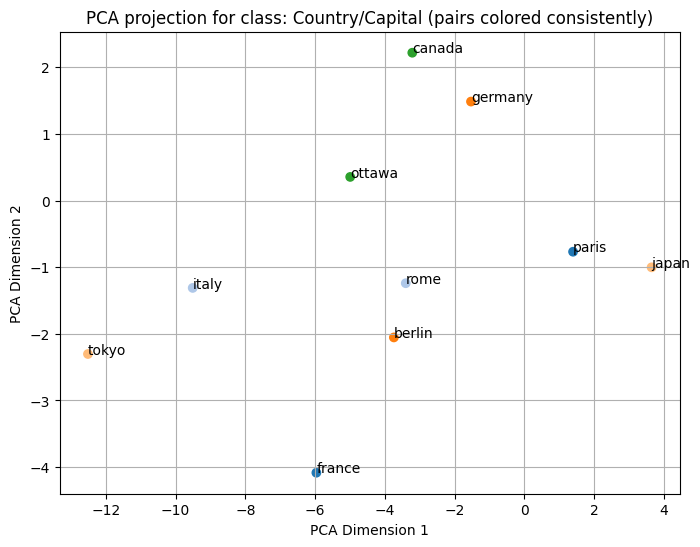

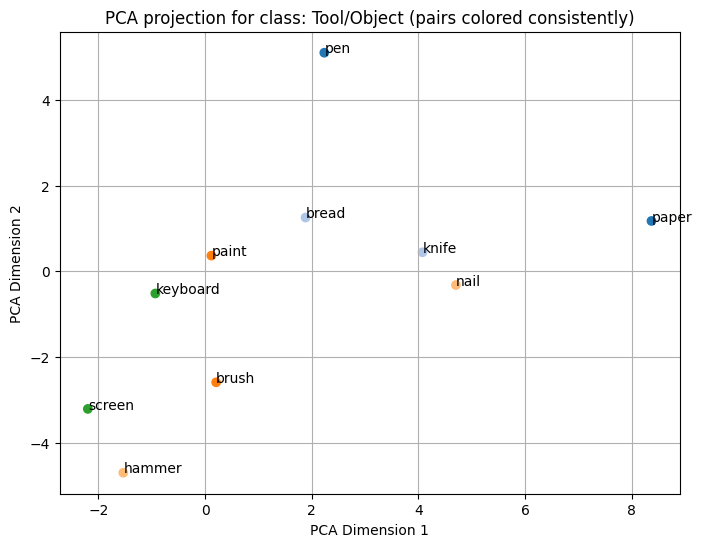

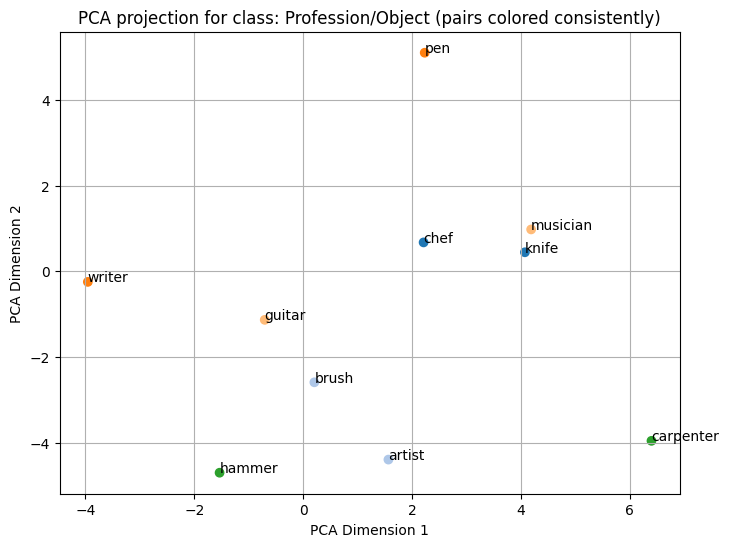

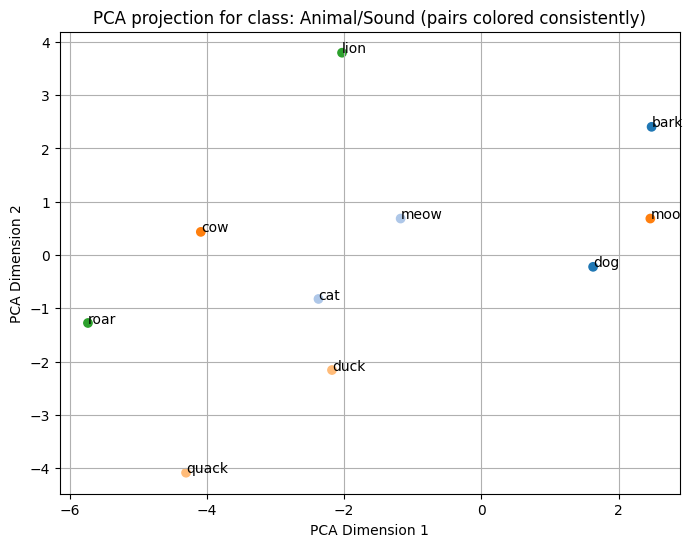

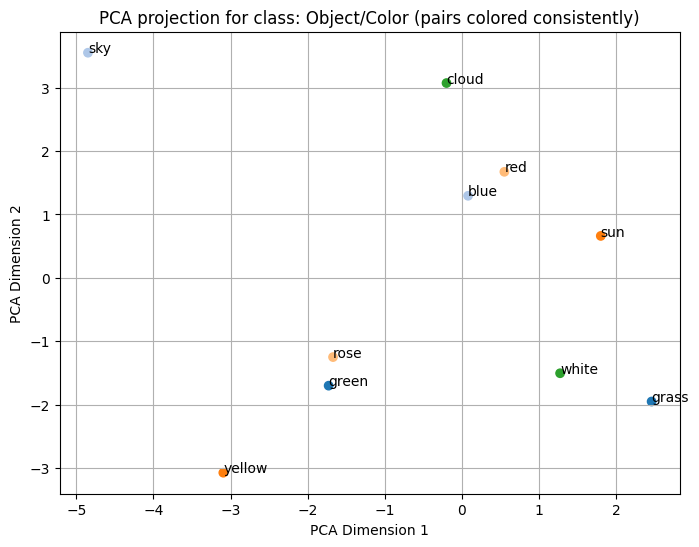

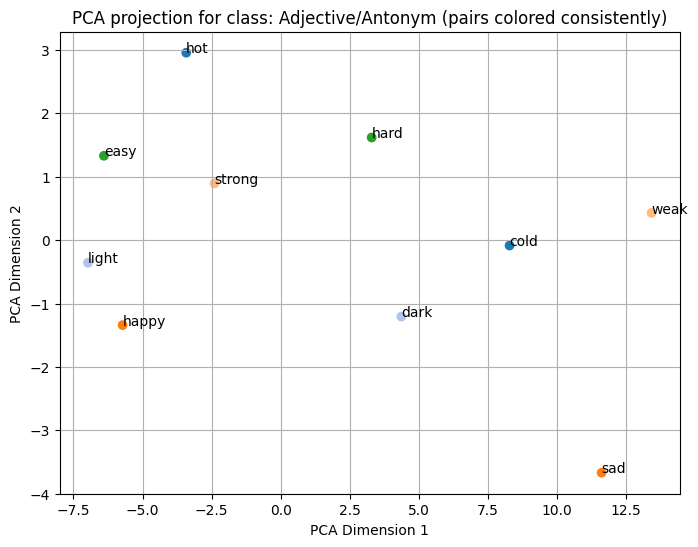

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# --- Przygotowanie danych ---

# 1. Zbierz wszystkie unikalne słowa z valid_classes (zakładamy, że valid_classes jest już dostępne)
all_words = []
for pairs in valid_classes.values():
    for w1, w2 in pairs:
        all_words.append(w1)
        all_words.append(w2)
all_words = list(set(all_words))

word_ids = [vocab[w] for w in all_words]
word_embeddings = embeddings[word_ids]

# --- PCA ---
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# --- Mapowanie słowa do współrzędnych 2D ---
word_to_coord = {w: word_embeddings_2d[i] for i, w in enumerate(all_words)}

# --- Funkcja do wygenerowania kolorów dla par ---
def get_colors(num_pairs):
    # Zwróć listę num_pairs unikalnych kolorów z palety 'tab20'
    base_cmap = cm.get_cmap('tab20')
    colors = [base_cmap(i % 20) for i in range(num_pairs)]
    return colors

# --- Rysowanie globalnego wykresu (wszystkie słowa) ---

plt.figure(figsize=(14, 10))
plt.title("Global PCA of all 100 words — pairs colored consistently")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)

pair_colors = []
pair_index = 0

# Stwórz słownik klasy: kolorów dla par
pair_color_map = {}

for class_name, pairs in valid_classes.items():
    colors = get_colors(len(pairs))  # kolory dla par w danej klasie
    for i, (w1, w2) in enumerate(pairs):
        c = colors[i]
        pair_color_map[(w1, w2)] = c

# Rysujemy punkty i podpisy globalnie z kolorami wg par
for class_name, pairs in valid_classes.items():
    for (w1, w2) in pairs:
        c = pair_color_map[(w1, w2)]
        x1, y1 = word_to_coord[w1]
        x2, y2 = word_to_coord[w2]
        plt.scatter([x1, x2], [y1, y2], color=[c, c], label=f"{w1}-{w2}")
        plt.text(x1, y1, w1, fontsize=9)
        plt.text(x2, y2, w2, fontsize=9)

plt.show()

# --- Rysowanie oddzielnych wykresów dla każdej klasy ---

for class_name, pairs in valid_classes.items():
    plt.figure(figsize=(8, 6))
    plt.title(f"PCA projection for class: {class_name} (pairs colored consistently)")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)

    colors = get_colors(len(pairs))

    for i, (w1, w2) in enumerate(pairs):
        c = colors[i]
        x1, y1 = word_to_coord[w1]
        x2, y2 = word_to_coord[w2]
        plt.scatter([x1, x2], [y1, y2], color=[c, c])
        plt.text(x1, y1, w1, fontsize=10)
        plt.text(x2, y2, w2, fontsize=10)

    plt.show()


<ipython-input-254-373939b3f46a>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_pairs)


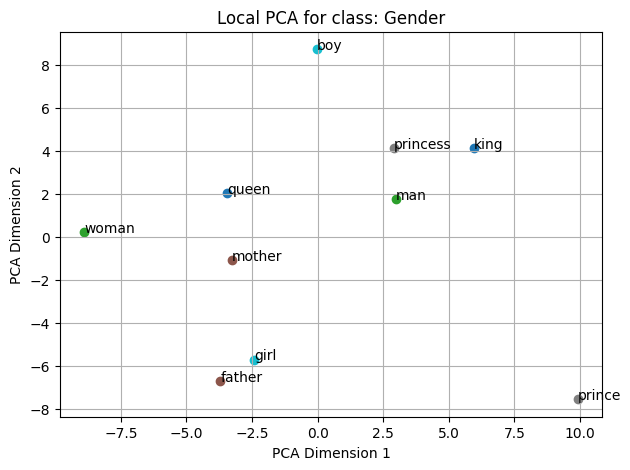

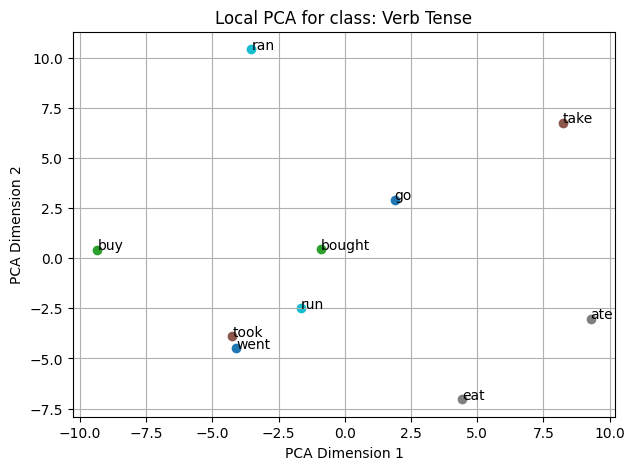

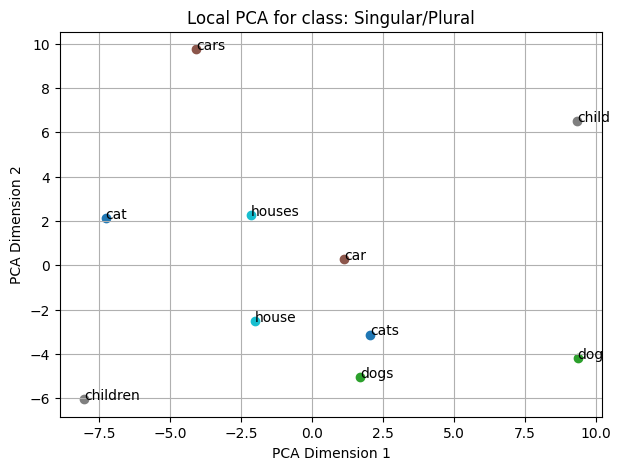

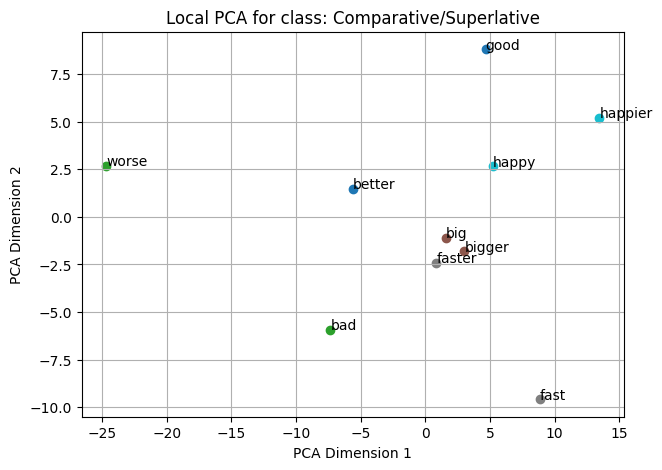

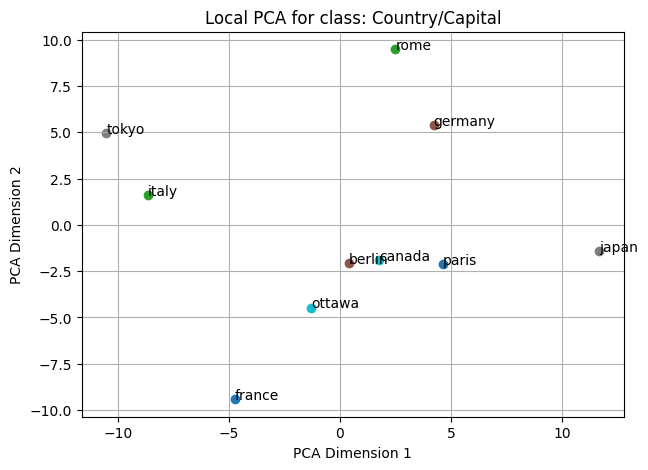

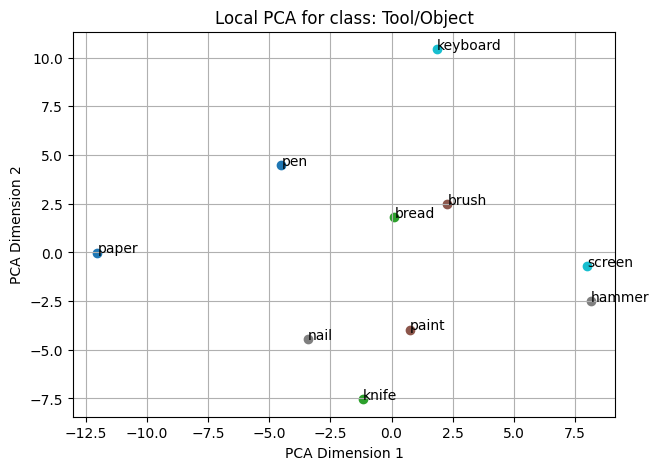

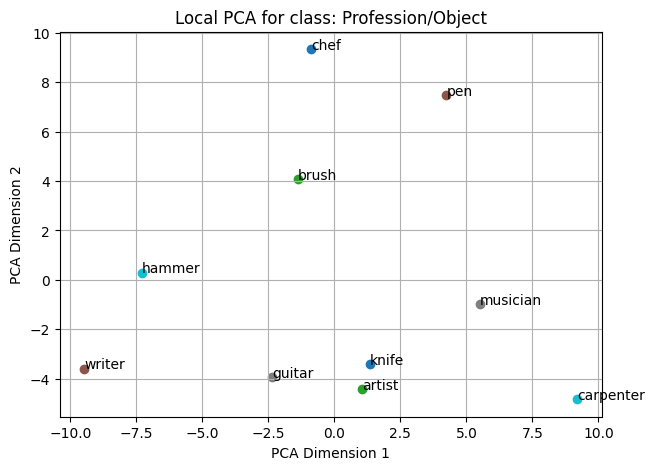

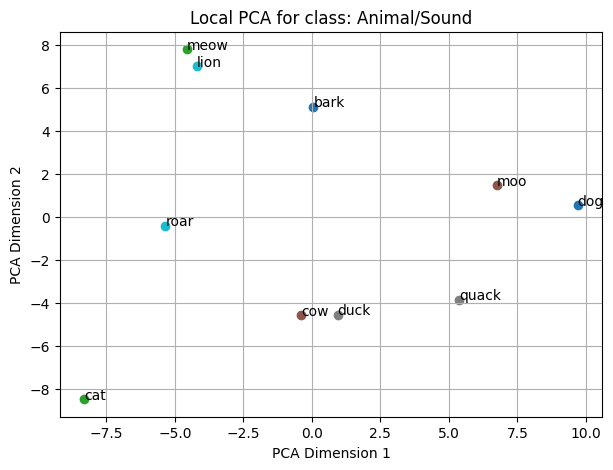

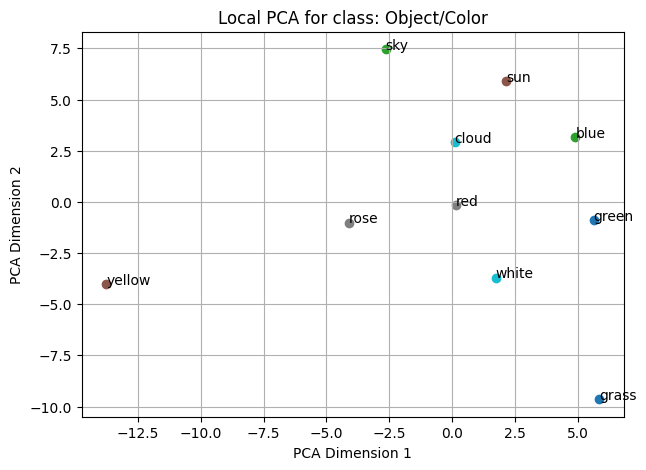

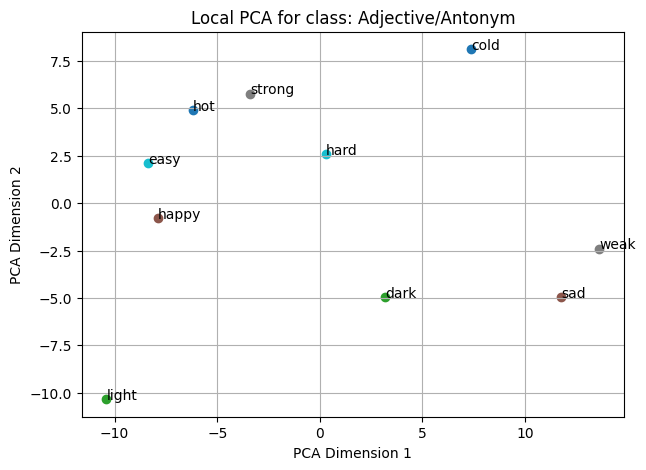

In [254]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Wydzielmy funkcję generującą mapowanie kolorów par (5 par na klasę)
def get_pair_colors(num_pairs=5):
    cmap = cm.get_cmap('tab10', num_pairs)
    return [cmap(i) for i in range(num_pairs)]

pair_colors = get_pair_colors(5)

for class_name, pairs in valid_classes.items():
    # 10 słów (5 par)
    class_words = []
    for w1, w2 in pairs:
        class_words.append(w1)
        class_words.append(w2)

    class_word_ids = [vocab[w] for w in class_words]
    class_embeddings = embeddings[class_word_ids]

    pca = PCA(n_components=2)
    class_emb_2d = pca.fit_transform(class_embeddings)

    word_to_coord = {w: class_emb_2d[i] for i, w in enumerate(class_words)}

    plt.figure(figsize=(7, 5))
    plt.title(f"Local PCA for class: {class_name}")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)

    for i, (w1, w2) in enumerate(pairs):
        color = pair_colors[i]  # dokładnie ten sam kolor co w globalnym PCA
        x1, y1 = word_to_coord[w1]
        x2, y2 = word_to_coord[w2]
        plt.scatter(x1, y1, color=color)
        plt.scatter(x2, y2, color=color)
        plt.text(x1, y1, w1, fontsize=10)
        plt.text(x2, y2, w2, fontsize=10)

    plt.show()


In [255]:
# Odwróć mapę: indeks -> słowo
id_to_word_temp = {idx: word for word, idx in vocab.items()}
embedding_matrix = net_64.embedding.weight.data.cpu()  # shape: (vocab_size, embedding_dim)
N = embedding_matrix.shape[0]
id_to_word = {i: id_to_word_temp.get(i, '<UNK>') for i in range(N)}

In [1]:
import torch

def find_nearest_words(v, embedding_matrix, id_to_word, topk=5):
    dists = torch.norm(embedding_matrix - v.unsqueeze(0), dim=1)
    # Bierzemy na zapas dużo więcej, żeby ominąć <UNK>
    topk_ids = torch.topk(dists, k=topk*10, largest=False).indices

    results = []
    for idx in topk_ids:
        word = id_to_word.get(idx.item(), '<UNK>')
        if word != '<UNK>':
            results.append((word, dists[idx].item()))
        if len(results) == topk:
            break

    return results

def get_embedding(word, vocab, embedding_matrix, unk_id=1):
    idx = vocab.get(word, unk_id)
    return embedding_matrix[idx]

In [2]:
v = get_embedding("bark", vocab, embedding_matrix) - get_embedding("dog", vocab, embedding_matrix) + get_embedding("meow", vocab, embedding_matrix)
nearest_words = find_nearest_words_cosine(v, embedding_matrix, id_to_word, topk=5)
for word, dist in nearest_words:
    print(f"{word:15}  dist = {dist:.4f}")


NameError: name 'vocab' is not defined

In [3]:
def show_token(word, vocab):
    token_id = vocab.get(word)
    if token_id is None:
        print(f"Słowo '{word}' nie występuje w słowniku (UNK).")
    else:
        print(f"Słowo '{word}' ma token ID: {token_id}")
show_token("man", vocab)
show_token("unknownword", vocab)


NameError: name 'vocab' is not defined

In [ ]:
import torch
import torch.nn.functional as F

def find_nearest_words_cosine(v, embedding_matrix, id_to_word, topk=5):
    # Normalizujemy wektory
    v_norm = F.normalize(v.unsqueeze(0), dim=1)  # [1, D]
    emb_norm = F.normalize(embedding_matrix, dim=1)  # [V, D]

    # Obliczamy cosine similarity i przekształcamy na dystans
    cosine_sim = torch.mm(emb_norm, v_norm.T).squeeze()  # [V]
    cosine_dist = 1 - cosine_sim  # Im mniejszy, tym bliżej

    # Wybieramy więcej kandydatów, żeby pominąć <UNK>
    topk_ids = torch.topk(cosine_dist, k=topk * 10, largest=False).indices

    results = []
    for idx in topk_ids:
        word = id_to_word.get(idx.item(), '<UNK>')
        if word != '<UNK>':
            results.append((word, cosine_dist[idx].item()))
        if len(results) == topk:
            break

    return results


In [258]:
# Przykład: emb("king") - emb("man") + emb("woman")


A = "king"
B = "man"
C = "woman"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")


Top 5 nearest words:
  woman           dist = 17.8111
  king            dist = 20.5772
  abandoned       dist = 23.2297
  sicher          dist = 23.2736
  accesresto      dist = 23.3943


In [247]:
A = "bark"
B = "dog"
C = "lion"

v = get_embedding(B, vocab, embedding_matrix) \
  - get_embedding(A, vocab, embedding_matrix) \
  + get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")


Top 5 nearest words:
  lion            dist = 44.1910
  dog             dist = 45.5222
  helpings        dist = 60.2416
  nman            dist = 60.2842
  increased       dist = 60.3179
